In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, to_date, avg, count
import json
import matplotlib.pyplot as plt
import numpy as np


spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MySparkApp") \
    .getOrCreate()


25/03/29 13:31:05 WARN Utils: Your hostname, ana resolves to a loopback address: 127.0.1.1; using 192.168.110.240 instead (on interface wlo1)
25/03/29 13:31:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/29 13:31:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Cargamos los datasets modificados de XM, BR y US
data_set_MX = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/MX.csv")
data_set_BR = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/BR.csv")
data_set_US = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/US.csv")

# contar cuantos videos tiene en cada daataset
print("Cantidad de videos en MX: ", data_set_MX.count())
print("Cantidad de videos en BR: ", data_set_BR.count())
print("Cantidad de videos en US: ", data_set_US.count())

Cantidad de videos en MX:  268598
Cantidad de videos en BR:  268790
Cantidad de videos en US:  268787


In [3]:
# Cargar el json de las categorias para MX
with open("/home/shinening96/proyectoSpark/datasets/MX_category_id.json", "r") as file:
    data_set_categories_MX = json.load(file)

# Crear un diccionario con las categorias
categoriesMX = {}
for category in data_set_categories_MX["items"]:
    categoriesMX[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_MX = spark.createDataFrame(categoriesMX.items(), ["category_id", "category_name"])

data_set_categories_MX.show(truncate=False, n=100)


+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|1          |Film & Animation    |
|2          |Autos & Vehicles    |
|10         |Music               |
|15         |Pets & Animals      |
|17         |Sports              |
|18         |Short Movies        |
|19         |Travel & Events     |
|20         |Gaming              |
|21         |Videoblogging       |
|22         |People & Blogs      |
|23         |Comedy              |
|24         |Entertainment       |
|25         |News & Politics     |
|26         |Howto & Style       |
|27         |Education           |
|28         |Science & Technology|
|30         |Movies              |
|31         |Anime/Animation     |
|32         |Action/Adventure    |
|33         |Classics            |
|34         |Comedy              |
|35         |Documentary         |
|36         |Drama               |
|37         |Family              |
|38         |Foreign             |
|39         |Horror 

In [4]:
# Cargar el json de las categorias para BR
with open("/home/shinening96/proyectoSpark/datasets/BR_category_id.json", "r") as file:
    data_set_categories_BR = json.load(file)

# Crear un diccionario con las categorias
categoriesBR = {}
for category in data_set_categories_BR["items"]:
    categoriesBR[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_BR = spark.createDataFrame(categoriesBR.items(), ["category_id", "category_name"])

data_set_categories_BR.show(truncate=False, n=100)


+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|1          |Film & Animation    |
|2          |Autos & Vehicles    |
|10         |Music               |
|15         |Pets & Animals      |
|17         |Sports              |
|18         |Short Movies        |
|19         |Travel & Events     |
|20         |Gaming              |
|21         |Videoblogging       |
|22         |People & Blogs      |
|23         |Comedy              |
|24         |Entertainment       |
|25         |News & Politics     |
|26         |Howto & Style       |
|27         |Education           |
|28         |Science & Technology|
|30         |Movies              |
|31         |Anime/Animation     |
|32         |Action/Adventure    |
|33         |Classics            |
|34         |Comedy              |
|35         |Documentary         |
|36         |Drama               |
|37         |Family              |
|38         |Foreign             |
|39         |Horror 

In [5]:
# Cargar el json de las categorias para US
with open("/home/shinening96/proyectoSpark/datasets/US_category_id.json", "r") as file:
    data_set_categories_US = json.load(file)

# Crear un diccionario con las categorias
categoriesUS = {}
for category in data_set_categories_US["items"]:
    categoriesUS[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_US = spark.createDataFrame(categoriesUS.items(), ["category_id", "category_name"])

data_set_categories_US.show(truncate=False, n=100)


+-----------+---------------------+
|category_id|category_name        |
+-----------+---------------------+
|1          |Film & Animation     |
|2          |Autos & Vehicles     |
|10         |Music                |
|15         |Pets & Animals       |
|17         |Sports               |
|18         |Short Movies         |
|19         |Travel & Events      |
|20         |Gaming               |
|21         |Videoblogging        |
|22         |People & Blogs       |
|23         |Comedy               |
|24         |Entertainment        |
|25         |News & Politics      |
|26         |Howto & Style        |
|27         |Education            |
|28         |Science & Technology |
|29         |Nonprofits & Activism|
|30         |Movies               |
|31         |Anime/Animation      |
|32         |Action/Adventure     |
|33         |Classics             |
|34         |Comedy               |
|35         |Documentary          |
|36         |Drama                |
|37         |Family         

In [15]:
# MEXICO
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_MX = data_set_MX.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultMX = data_set_with_diff_MX.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
).orderBy("categoryId")

# Mostrar el resultado con el nombre de la categoría
resultMX = resultMX.join(data_set_categories_MX, resultMX.categoryId == data_set_categories_MX.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
)

print("Resultado del dataset de México:\n")
resultMX.show(truncate=False, n=100)


Resultado del dataset de México:



+----------+--------------------+-----------------+-------------+------------------------------+-------------------+------------------+------------------+------------------+
|categoryId|category_name       |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views     |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+--------------------+-----------------+-------------+------------------------------+-------------------+------------------+------------------+------------------+
|1         |Film & Animation    |true             |73           |5.054794520547945             |5065399.767123288  |8496.753424657534 |23.602739726027398|0.0               |
|1         |Film & Animation    |false            |7156         |5.194522079373952             |2194907.8596981554 |85295.59013415316 |355.0445779765232 |4975.9670206819455|
|2         |Autos & Vehicles    |false            |2488         |4.768488745980707             |783176.182073955   |52957.28979099

In [16]:
# BRASIL
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_BR = data_set_BR.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultBR = data_set_with_diff_BR.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
).orderBy("categoryId")

# Mostrar el resultado con el nombre de la categoría
resultBR = resultBR.join(data_set_categories_BR, resultBR.categoryId == data_set_categories_BR.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
)

print("Resultado del dataset de Brasil:\n")
resultBR.show(truncate=False, n=100)


Resultado del dataset de Brasil:



+----------+--------------------+-----------------+-------------+------------------------------+--------------------+------------------+------------------+------------------+
|categoryId|category_name       |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views      |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+--------------------+-----------------+-------------+------------------------------+--------------------+------------------+------------------+------------------+
|1         |Film & Animation    |true             |32           |4.125                         |3607466.96875       |0.0               |0.0               |0.0               |
|1         |Film & Animation    |false            |3297         |4.174704276615104             |1990123.1067637247  |78551.4440400364  |374.0400363967243 |4939.723688201395 |
|2         |Autos & Vehicles    |true             |7            |5.714285714285714             |1686720.857142857   |0.0     

In [17]:
# ESTADOS UNIDOS
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_US = data_set_US.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultUS = data_set_with_diff_US.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
).orderBy("categoryId")

# Mostrar el resultado con el nombre de la categoría
resultUS = resultUS.join(data_set_categories_US, resultUS.categoryId == data_set_categories_US.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
)

print("Resultado del dataset de Estados Unidos:\n")
resultUS.show(truncate=False, n=100)


Resultado del dataset de Estados Unidos:



+----------+---------------------+-----------------+-------------+------------------------------+------------------+------------------+------------------+------------------+
|categoryId|category_name        |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views    |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+---------------------+-----------------+-------------+------------------------------+------------------+------------------+------------------+------------------+
|1         |Film & Animation     |true             |112          |3.4285714285714284            |3485320.0         |10253.99107142857 |674.7767857142857 |0.0               |
|1         |Film & Animation     |false            |10811        |3.21737119600407              |2726762.7669040794|104367.77199149015|611.5130885209509 |7385.775968920544 |
|2         |Autos & Vehicles     |true             |6            |2.5                           |1543711.0         |41113.33333333

In [18]:
# mostrar los videos en el dataset US con categoria 19 y comentarios deshabilitados
data_set_US.filter((col("categoryId") == 19) & (col("comments_disabled") == True)).show(truncate=False, n=100)

+-----------+------------------+-------------------+------------------------+-------------------+----------+-------------------+------+----------+-----+--------+-------------+----------------------------------------------+-----------------+----------------+
|video_id   |title             |publishedAt        |channelId               |channelTitle       |categoryId|trending_date      |tags  |view_count|likes|dislikes|comment_count|thumbnail_link                                |comments_disabled|ratings_disabled|
+-----------+------------------+-------------------+------------------------+-------------------+----------+-------------------+------+----------+-----+--------+-------------+----------------------------------------------+-----------------+----------------+
|rWoEsIBYwn8|Guiding Stars 2022|2022-12-07 10:00:10|UCEeHmfGLcSga8gRlHCMt6zg|Google Local Guides|19        |2022-12-09 20:00:00|[None]|378090    |21011|0       |0            |https://i.ytimg.com/vi/rWoEsIBYwn8/default.jpg|true

In [9]:
# Convertir los resultados a Pandas para poder graficar los resultados
resultMXPandas = resultMX.toPandas()
resultBRPandas = resultBR.toPandas()
resultUSPandas = resultUS.toPandas()

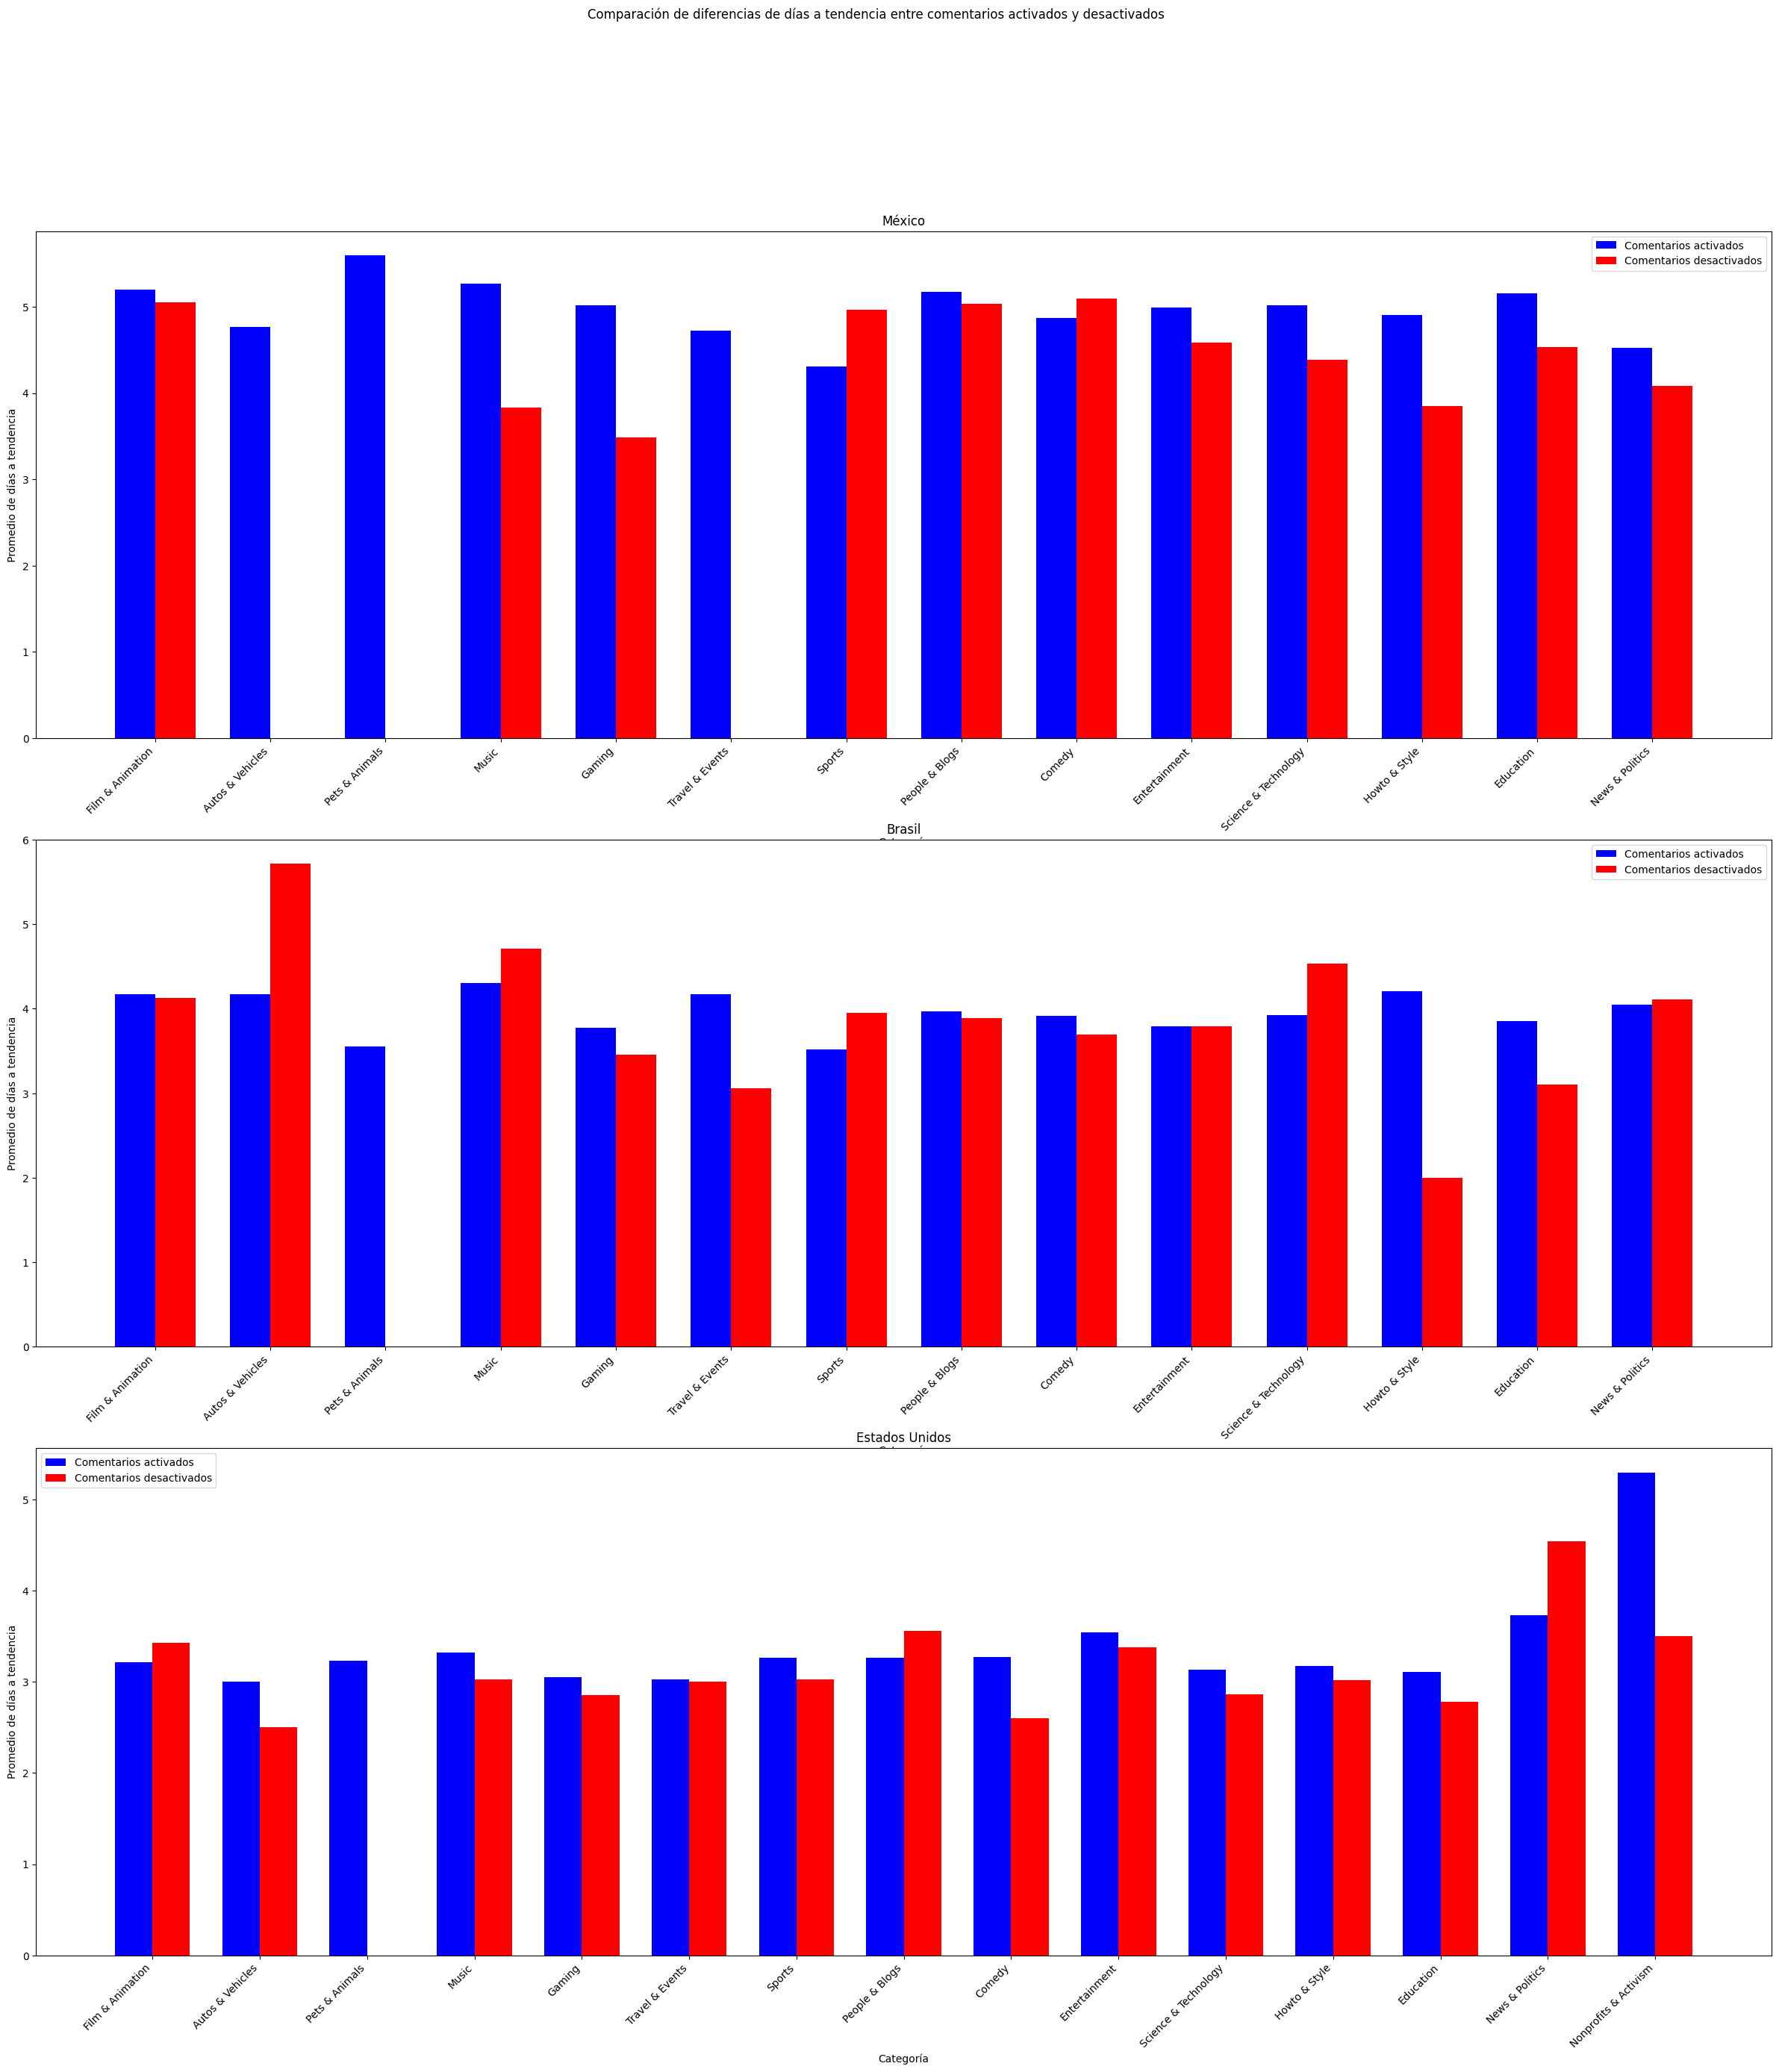

In [10]:
# comparacion de diferencias de días a tendencia entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de diferencias de días a tendencia entre comentarios activados y desactivados")

# MX
resultMXCommentsEnabled = resultMXPandas[resultMXPandas["comments_disabled"] == False]
resultMXCommentsDisabled = resultMXPandas[resultMXPandas["comments_disabled"] == True]

categoriesMXAligned = resultMXPandas["category_name"].unique()
resultMXCommentsEnabledAligned = resultMXCommentsEnabled.set_index("category_name").reindex(categoriesMXAligned).reset_index()
resultMXCommentsDisabledAligned = resultMXCommentsDisabled.set_index("category_name").reindex(categoriesMXAligned).reset_index()

x = np.arange(len(categoriesMXAligned))
width = 0.35

axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="red", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de días a tendencia")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
resultBRCommentsEnabled = resultBRPandas[resultBRPandas["comments_disabled"] == False]
resultBRCommentsDisabled = resultBRPandas[resultBRPandas["comments_disabled"] == True]

categoriesBRAligned = resultBRPandas["category_name"].unique()
resultBRCommentsEnabledAligned = resultBRCommentsEnabled.set_index("category_name").reindex(categoriesBRAligned).reset_index()
resultBRCommentsDisabledAligned = resultBRCommentsDisabled.set_index("category_name").reindex(categoriesBRAligned).reset_index()

x = np.arange(len(categoriesBRAligned))

axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="red", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de días a tendencia")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
resultUSCommentsEnabled = resultUSPandas[resultUSPandas["comments_disabled"] == False]
resultUSCommentsDisabled = resultUSPandas[resultUSPandas["comments_disabled"] == True]

categoriesUSAligned = resultUSPandas["category_name"].unique()
resultUSCommentsEnabledAligned = resultUSCommentsEnabled.set_index("category_name").reindex(categoriesUSAligned).reset_index()
resultUSCommentsDisabledAligned = resultUSCommentsDisabled.set_index("category_name").reindex(categoriesUSAligned).reset_index()

x = np.arange(len(categoriesUSAligned))

axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="red", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de días a tendencia")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


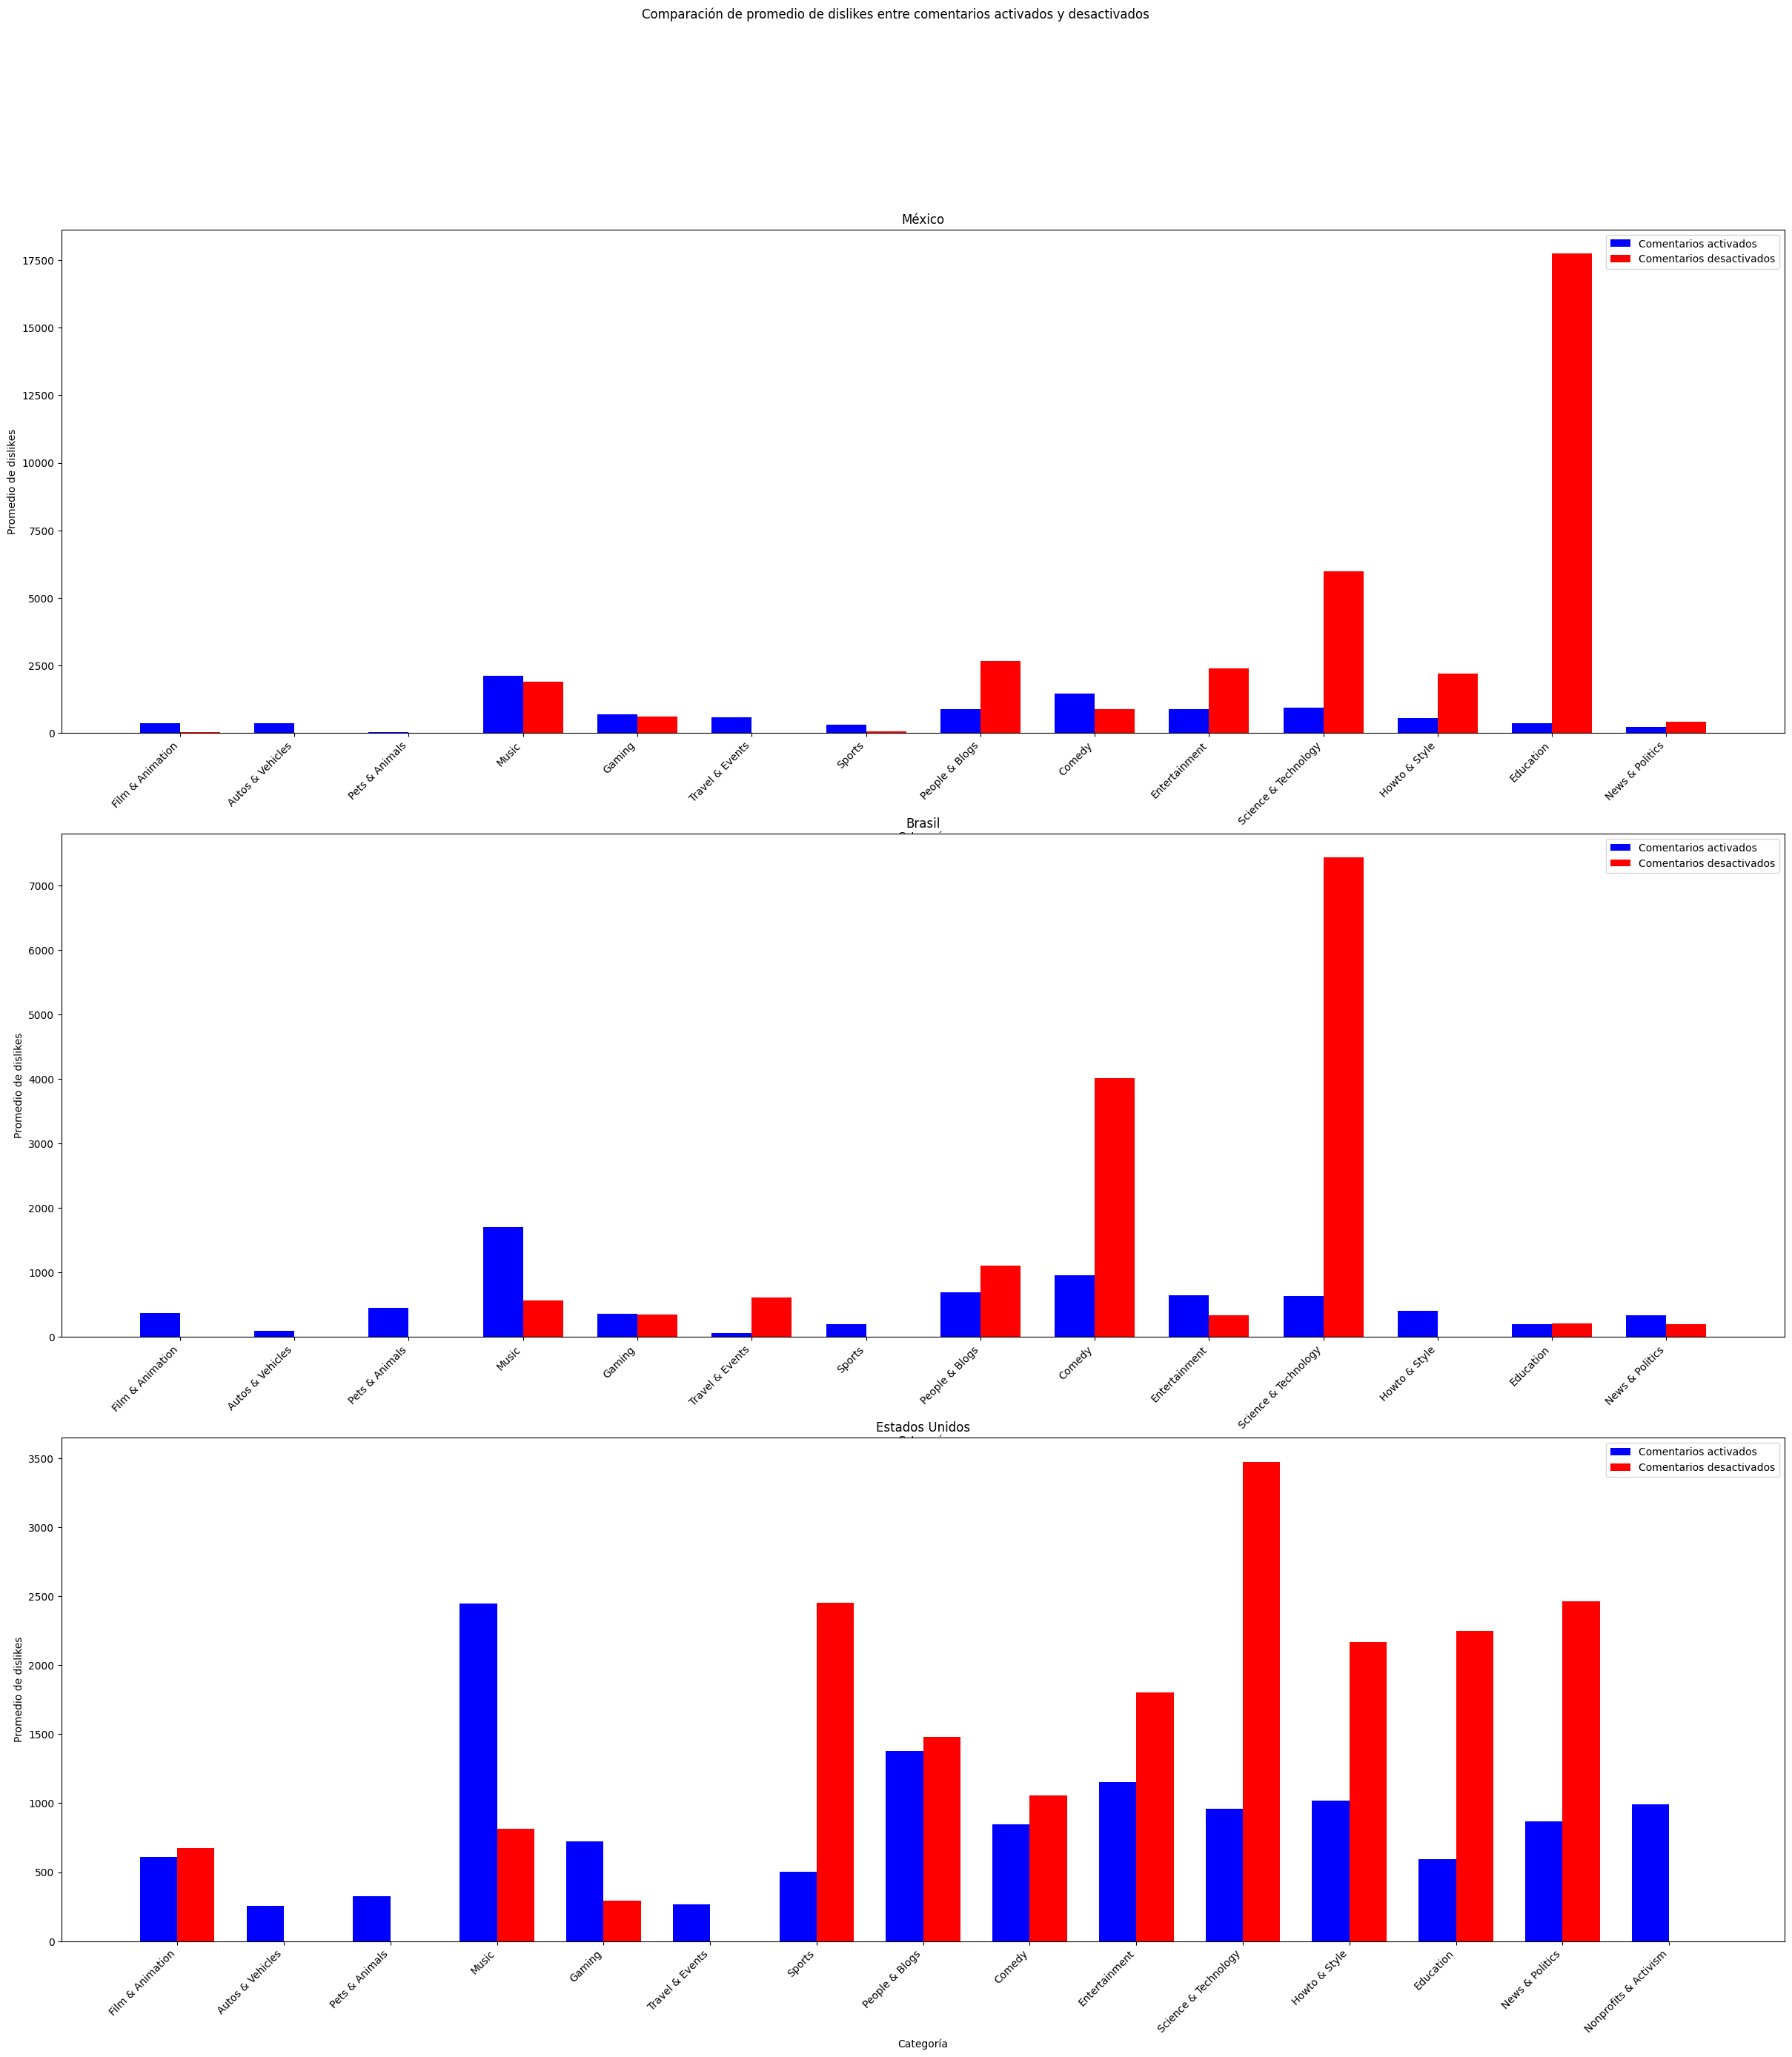

In [11]:
# Comparación de promedio de dislikes entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de dislikes entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de dislikes")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de dislikes")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de dislikes")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


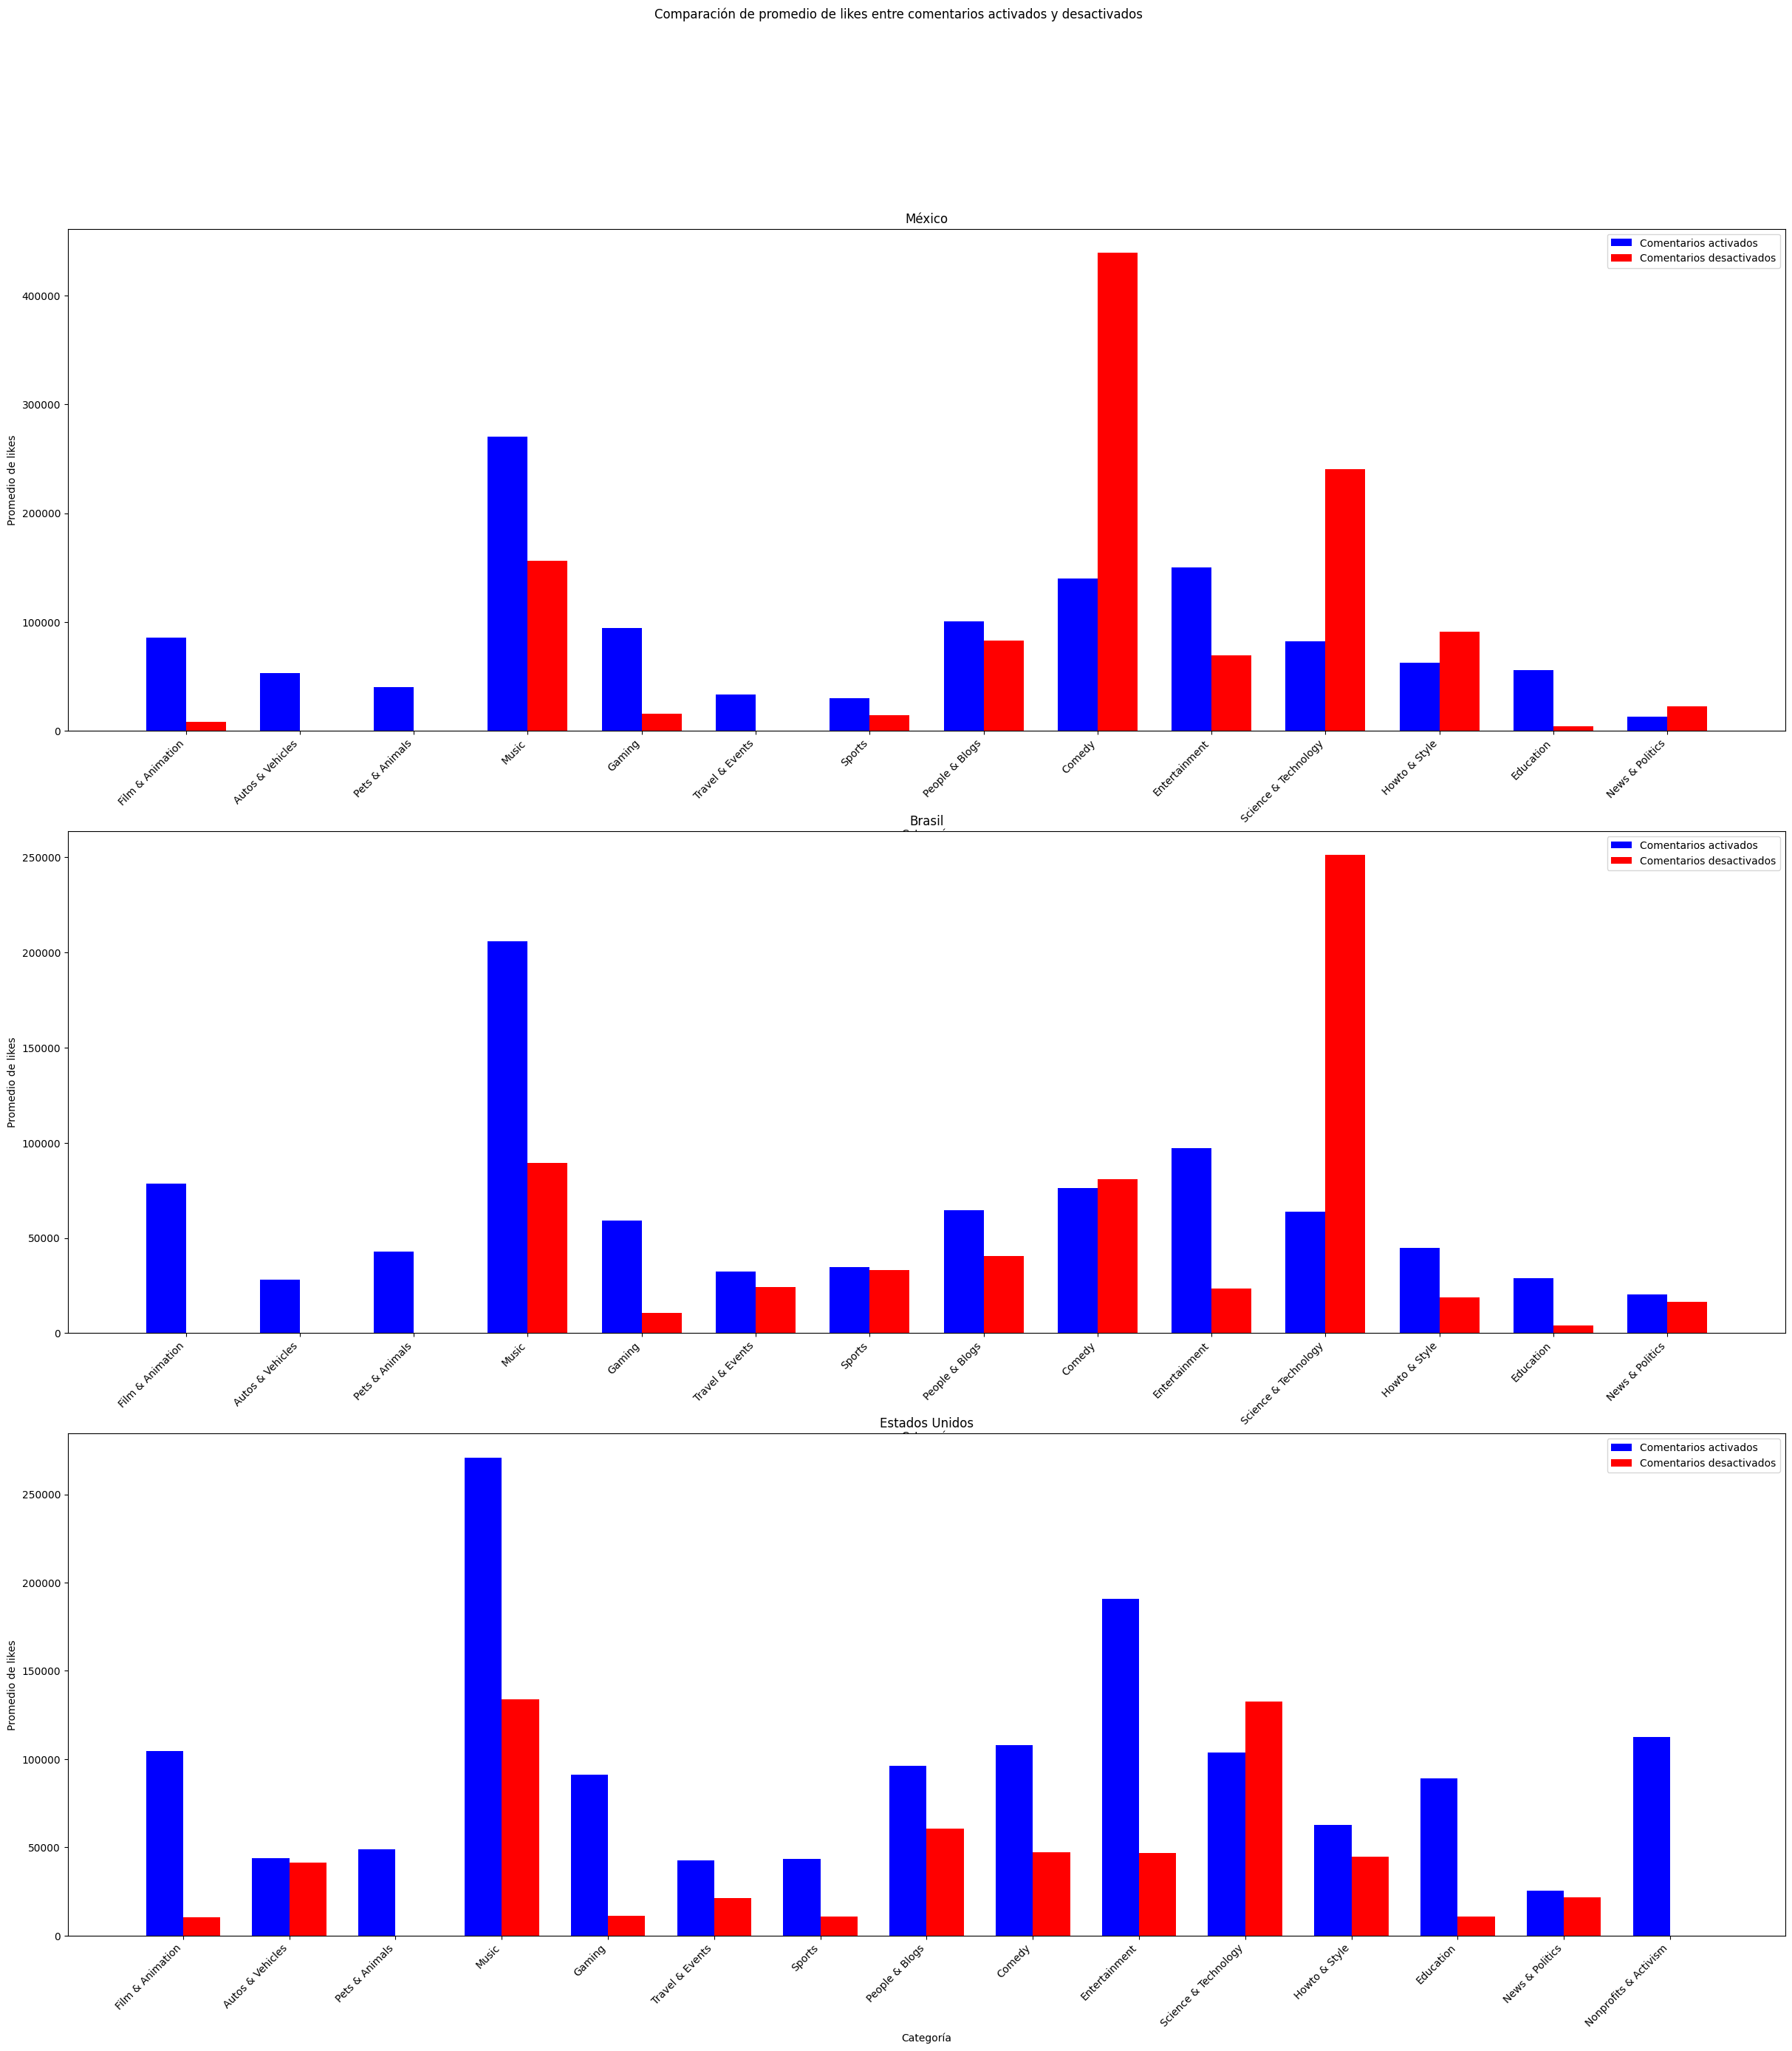

In [12]:
# Comparación de promedio de likes entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de likes entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de likes")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de likes")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de likes")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


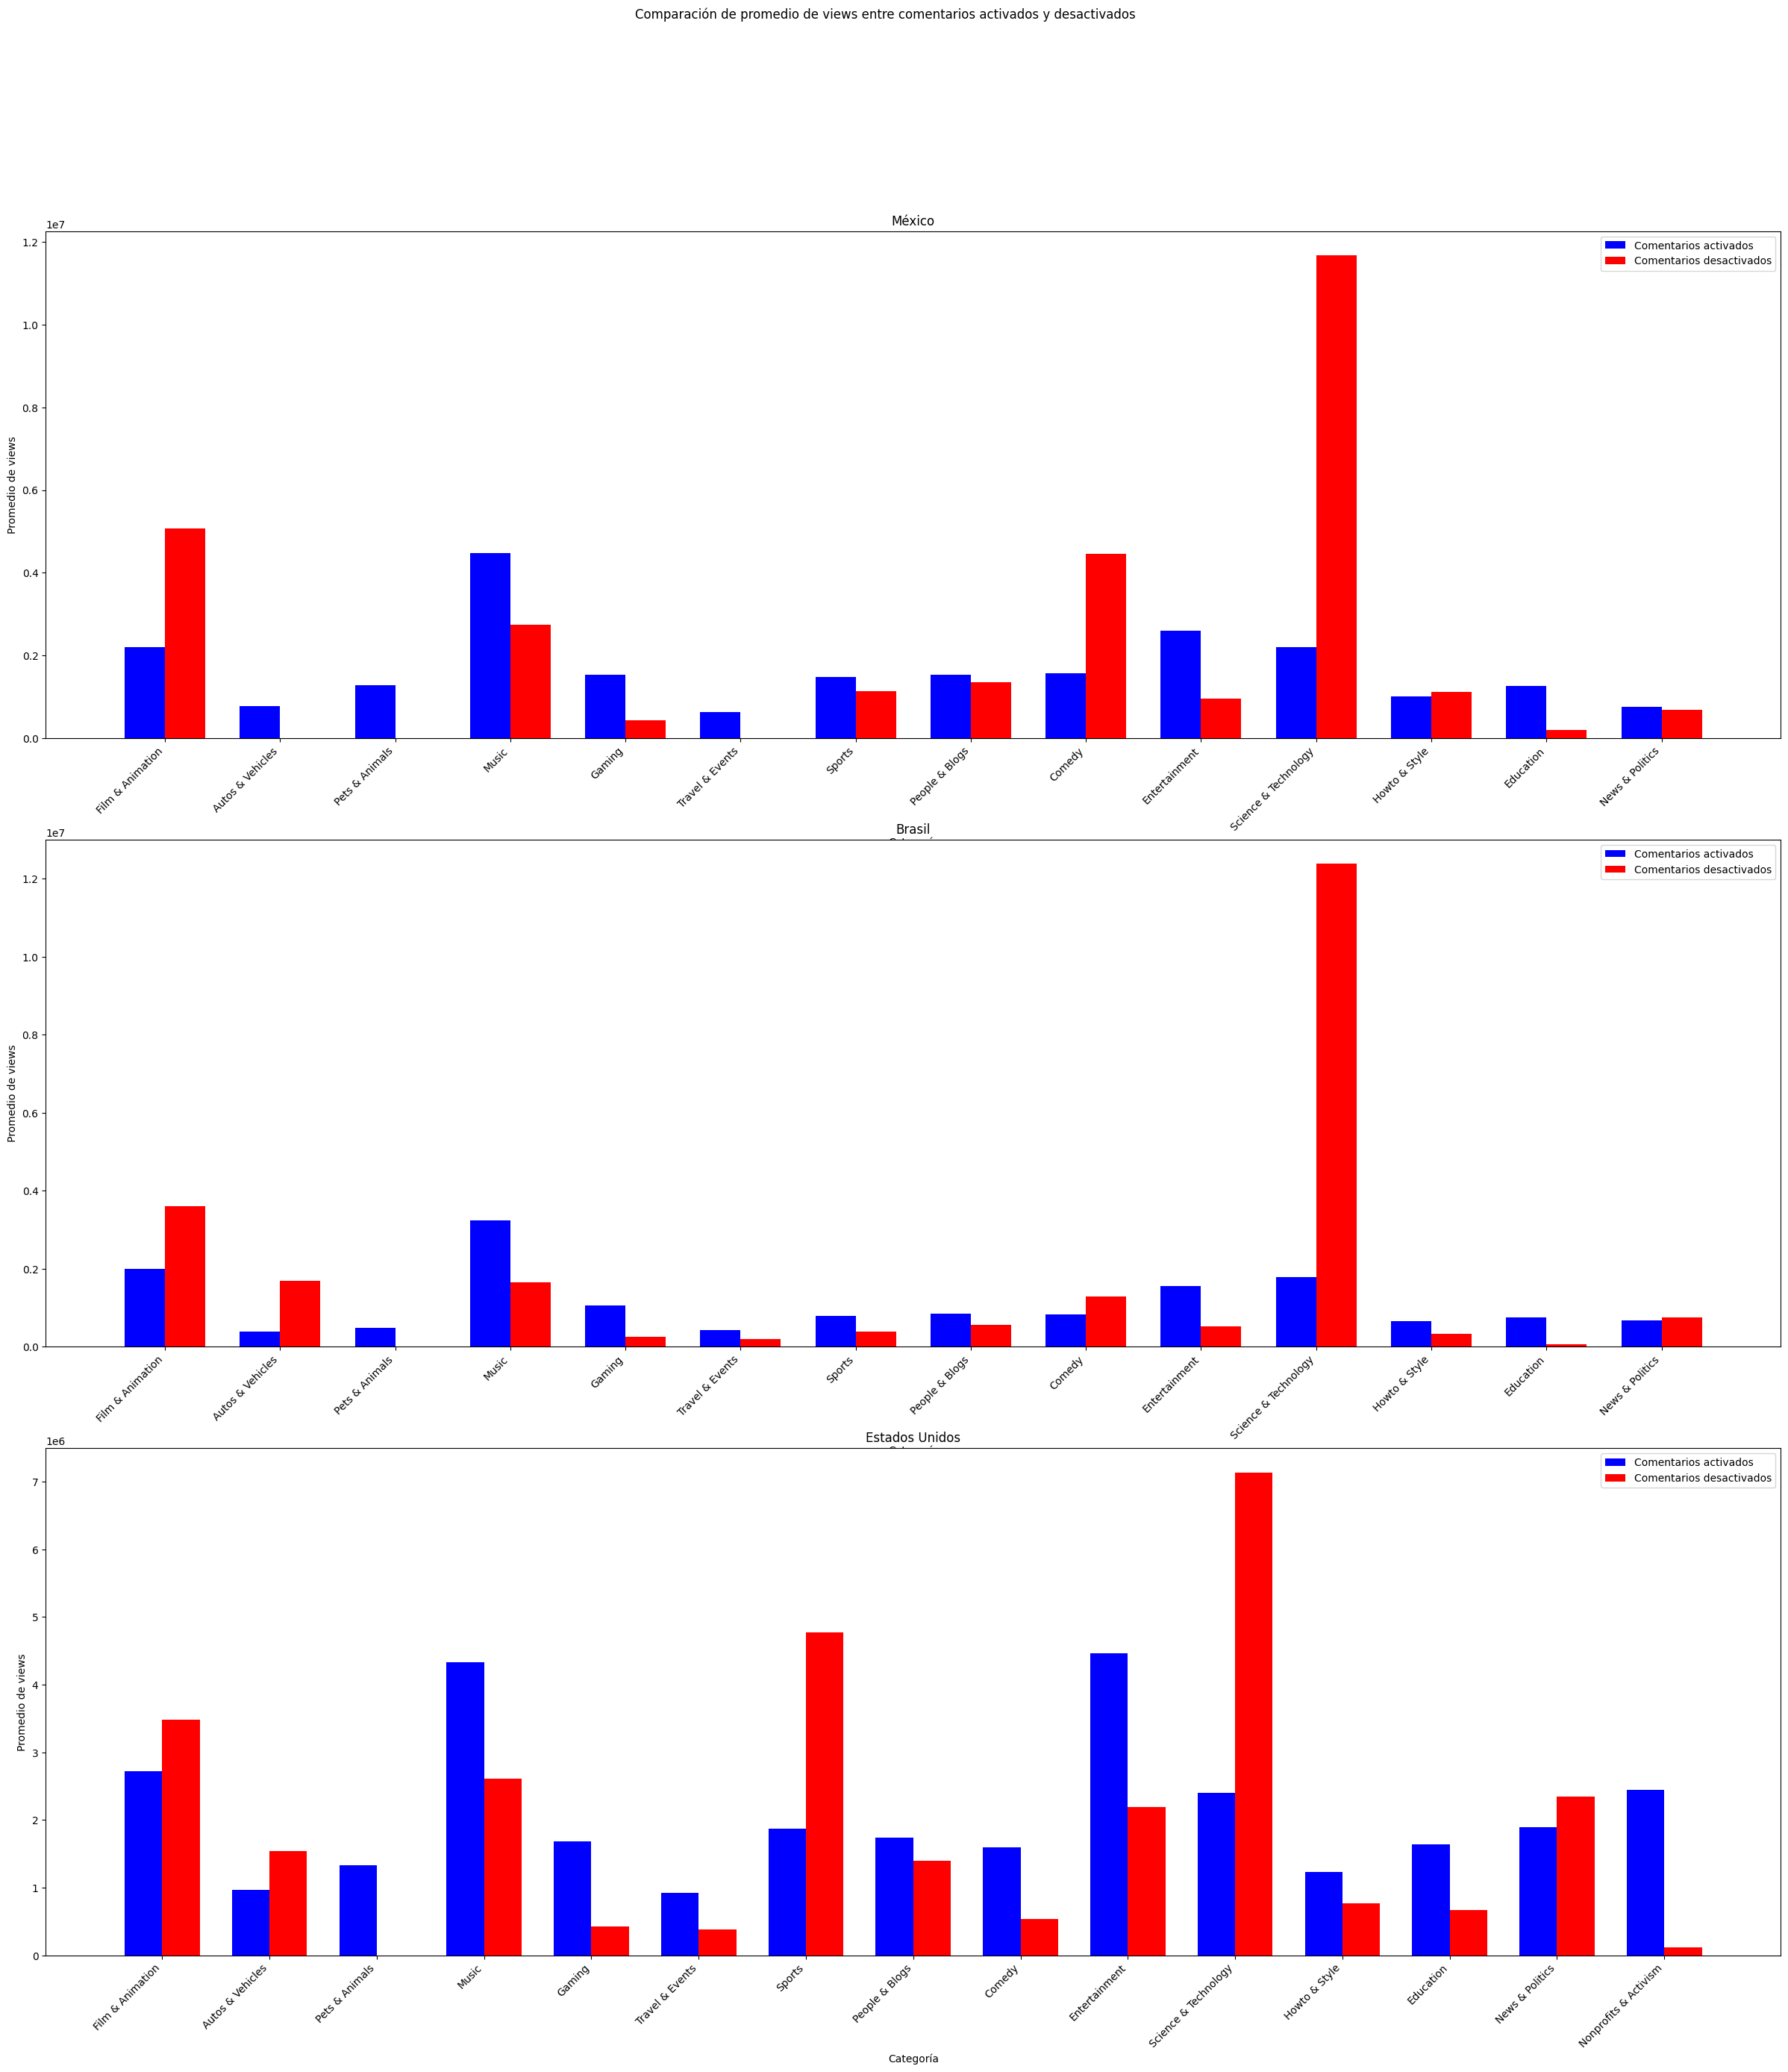

In [13]:
# Comparación de promedio de views entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de views entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_views"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de views")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_views"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de views")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_views"].fillna(0), width, color="red", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de views")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


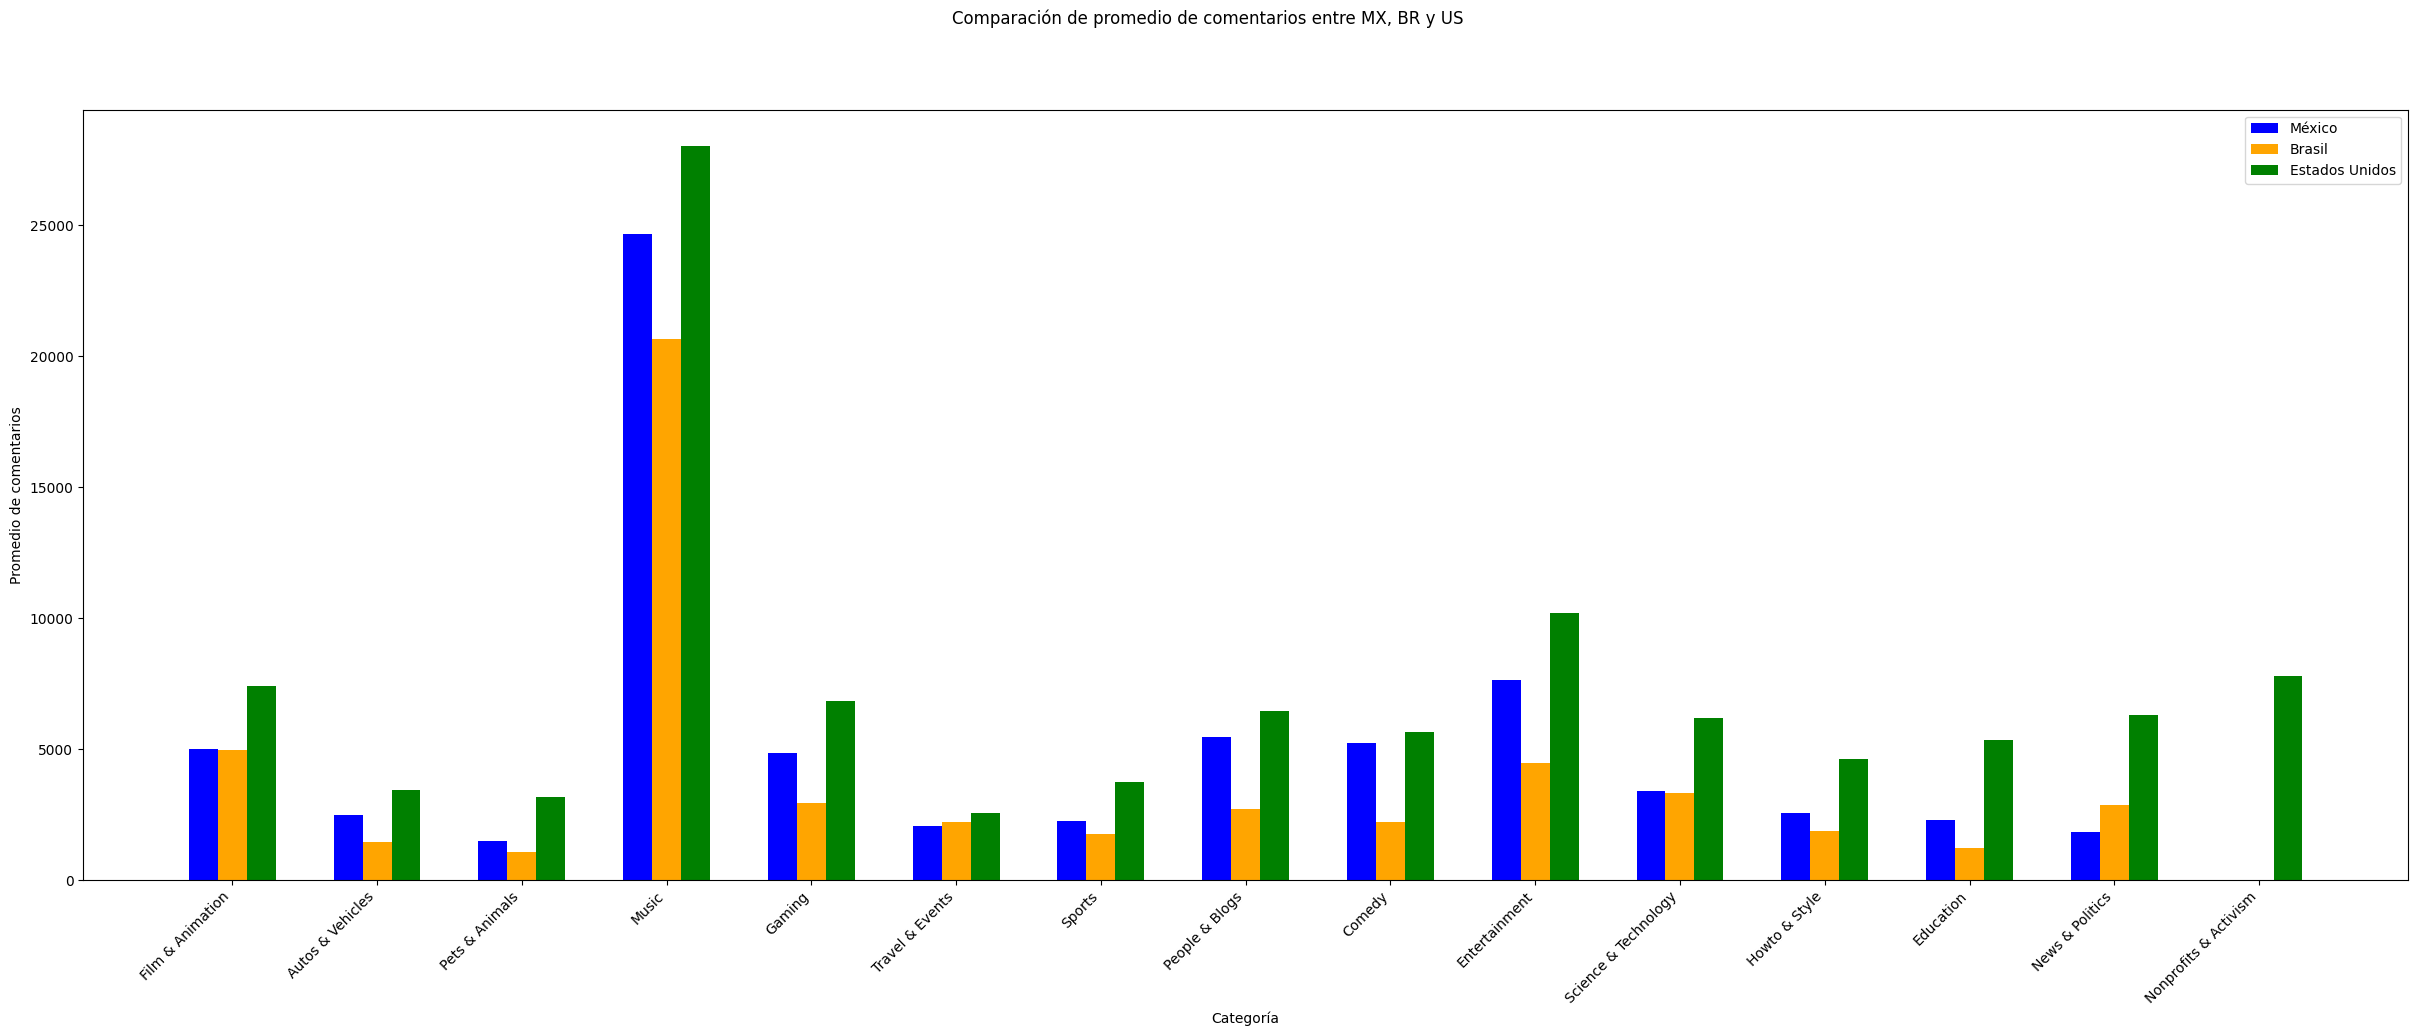

In [14]:
# Disminuir el ancho de las barras
width = 0.2

# Comparación de promedio de comentarios entre MX, BR y US
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
fig.suptitle("Comparación de promedio de comentarios entre MX, BR y US")

categoriesMXAligned = resultMXCommentsEnabledAligned["category_name"]
categoriesBRAligned = resultBRCommentsEnabledAligned["category_name"]
categoriesUSAligned = resultUSCommentsEnabledAligned["category_name"]

xMX = np.arange(len(categoriesMXAligned))
xBR = np.arange(len(categoriesBRAligned))
xUS = np.arange(len(categoriesUSAligned))

axs.bar(xMX - width, resultMXCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="blue", label="México")
axs.bar(xBR, resultBRCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="orange", label="Brasil")
axs.bar(xUS + width, resultUSCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="green", label="Estados Unidos")

axs.set_xticks(np.arange(max(len(categoriesMXAligned), len(categoriesBRAligned), len(categoriesUSAligned))))
axs.set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs.set_ylabel("Promedio de comentarios")
axs.set_xlabel("Categoría")
axs.legend()

plt.show()
